In [1]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [2]:
import numpy as np
import functools
import random
import datetime
import scipy
import h5py
import os
import pathlib
import nrrd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib
import sys
import json
import skimage
from skimage import io, draw
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def create_dataset(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2) #113
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.359))
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                img =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                img = np.transpose(img, (2, 1, 0))
                img = img[::-1, :, :]
            
                img_data_array.append(img)
                # reading markups
                j = 0
            if (file.endswith(".json")) and j<1:
                #json_filename = glob(img_folder +  '/*.json')[-1]
                #data = open(json_filename,'r')
                json_path= os.path.join(img_folder, dir1, file)
                data = open(json_path,'r')
                
                jsondata = data.read()
                # Parse
                obj=json.loads(jsondata)
                list=obj['markups']
                # getting LPS coordinates
                points1 = list[0]["controlPoints"][0]["position"]
                points2 = list[0]["controlPoints"][1]["position"]
                points3 = list[0]["controlPoints"][2]["position"]
                # converting to i,j,k coordinate
                i1 = round((points1[0]-header['space origin'][0])/header['space directions'][0][0])
                j1 = round((points1[1]-header['space origin'][1])/header['space directions'][1][1])
                k1 = round((points1[2]-header['space origin'][2])/header['space directions'][2][2])
                i2 = round((points2[0]-header['space origin'][0])/header['space directions'][0][0])
                j2 = round((points2[1]-header['space origin'][1])/header['space directions'][1][1])
                k2 = round((points2[2]-header['space origin'][2])/header['space directions'][2][2])
                i3 = round((points3[0]-header['space origin'][0])/header['space directions'][0][0])
                j3 = round((points3[1]-header['space origin'][1])/header['space directions'][1][1])
                k3 = round((points3[2]-header['space origin'][2])/header['space directions'][2][2])
                # correcting coordinates of mask for resized image and creating mask
                i_s = int(round((i1-(i3-i1))*0.705))  # starting points of 3D cuboid box mask
                j_s = int(round((j1-(j2-j1))*0.588))

                i_e = int(round((i1+(i3-i1))*0.705))   # ending points of 3D cuboid box mask
                j_e = int(round((j1+(j2-j1))*0.588))
                
                k_s = int(round(k2-26)*0.21)  
                k_e = int(round(k2-22)*0.21)
                
                # Making 3D cuboid box mask
                rr, cc, dd = skimage.draw.rectangle(start=(i_s, j_s, k_s), end=(i_e, j_e, k_e)) 
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask[rr, cc, dd] = True
                mask = mask[:, ::-1, :]
                all_masks = [mask] * i
                mask_array.append(all_masks)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
### extract the image array and mask array
img_data_train, mask_all_train =create_dataset(r'C:/Dhruba Research Drive/Detection dataset/MNI LVO val')
#img_data_val, mask_all_val =create_dataset(r'C:/Dhruba Research Drive/5 nrrd per patient/Validation set')


## For Training Set ###
mask_all_train = combine_dims(mask_all_train, 0) # combines dimension 1 and 2
#imgs.shape
x1=np.array(img_data_train, np.float32)
#print(x1.shape)
y1=np.array(mask_all_train, np.float32)
#print(y1.shape)

X_val = np.expand_dims(x1, axis=4)
y_val = np.expand_dims(y1, axis=4)

print(X_val.shape)
print(y_val.shape)

(185, 128, 128, 32, 1)
(185, 128, 128, 32, 1)


In [4]:
best_model = load_model('detection_mni3mm_sen0.86spe0.38.hdf5', compile = False)

In [4]:
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d_113 (Conv3D)             (None, 128, 128, 32, 672         input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_114 (Conv3D)             (None, 128, 128, 32, 15576       conv3d_113[0][0]                 
__________________________________________________________________________________________________
max_pooling3d_26 (MaxPooling3D) (None, 64, 64, 16, 2 0           conv3d_114[0][0]                 
____________________________________________________________________________________________

In [121]:
layer = best_model.layers
filters, biases = best_model.layers[463].get_weights()
filters.shape

(3, 3, 3, 128, 64)

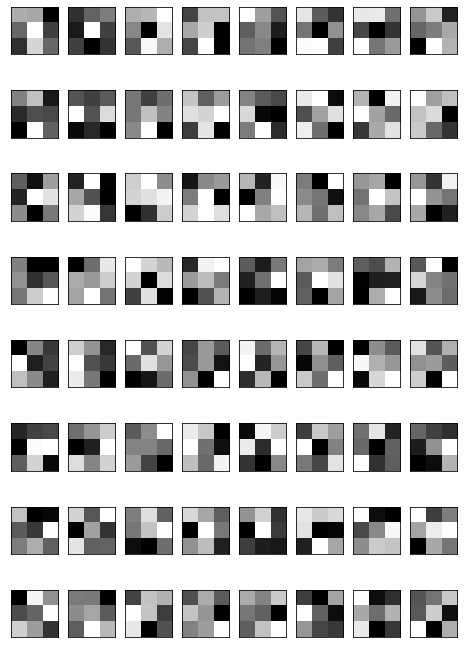

In [123]:
fig1=plt.figure(figsize=(8,12))
columns = 8
rows = 8
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:,:,:,:,i-1]
    fig1 = plt.subplot(rows, columns, i)
    fig1.set_xticks([]) #turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:,:,0,0], cmap='gray')
    
plt.show()

In [124]:
conv_layer_index = [109, 214, 463]
outputs = [best_model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=best_model.inputs, outputs=outputs)
print(model_short.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d_113 (Conv3D)             (None, 128, 128, 32, 672         input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_114 (Conv3D)             (None, 128, 128, 32, 15576       conv3d_113[0][0]                 
__________________________________________________________________________________________________
max_pooling3d_26 (MaxPooling3D) (None, 64, 64, 16, 2 0           conv3d_114[0][0]                 
___________________________________________________________________________________________

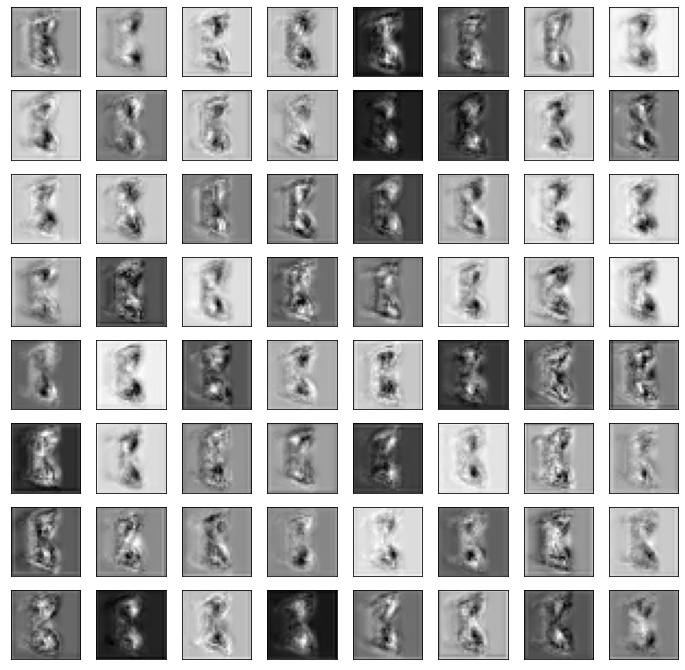

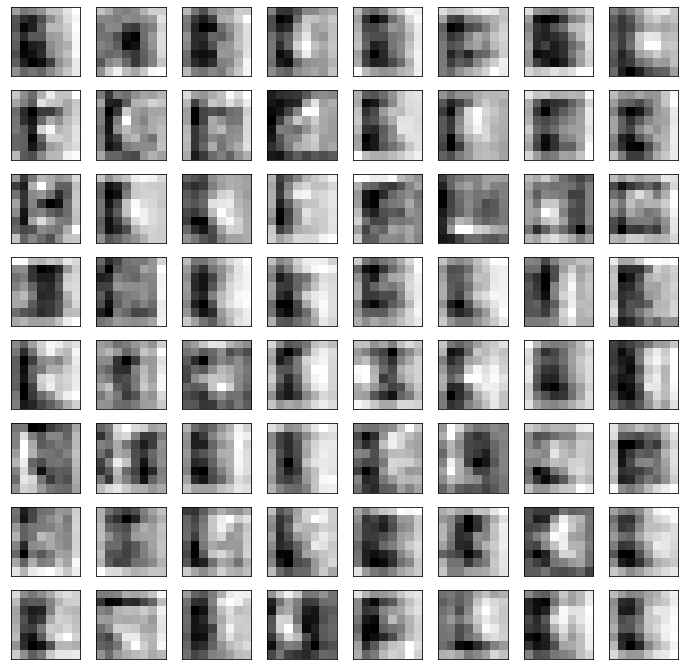

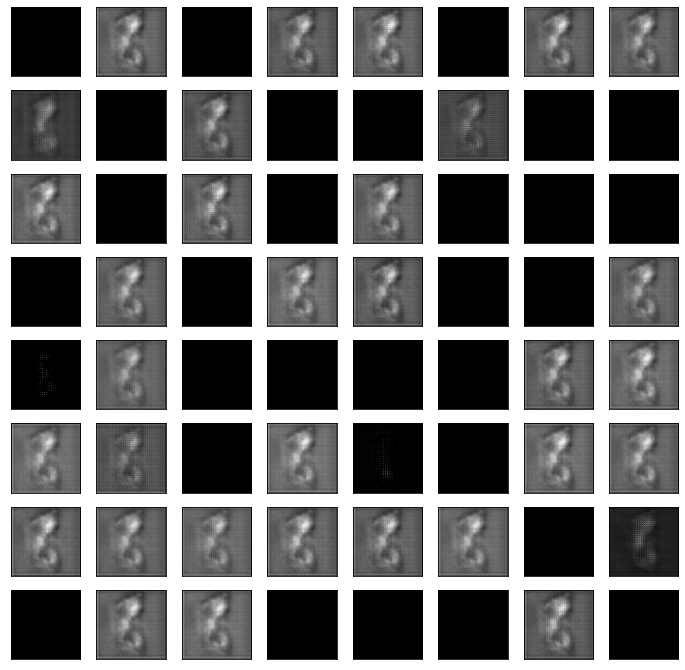

In [144]:
#test_img_number = random.randint(0, len(X_test))
test_img_number = 110
test_img = X_val[test_img_number]
ground_truth=y_val[test_img_number]

test_img_input = np.expand_dims(test_img, 0)

feature_output = model_short.predict(test_img_input)

columns = 8
rows = 8
n_filters = columns * rows
for ftr in feature_output:
    fig=plt.figure(figsize=(12,12))
    for i in range(1, columns*rows +1):
        fig = plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, 0, i-1], cmap='gray')
        
    plt.show()

(185, 128, 128, 32, 1)


(32, 128, 128)

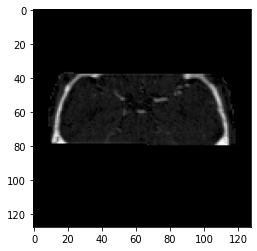

In [5]:
gamma = [.6]

img_aug_array= []


volume = np.power(X_val, gamma[0]) 
volume[volume < 0] = 0
        
X_train_aug4 = np.array(volume, np.float32)
#X_train_aug4 = np.expand_dims(X_train_aug4, axis=4)
print(X_train_aug4.shape)

img = X_train_aug4[1]
vol = np.transpose(img, (2, 1, 0, 3))
vol = vol[:, :, :, 0]
plt.imshow(vol[9], cmap = 'gray')
vol.shape

C:\Users\dhruba\.conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(128, 128, 32)


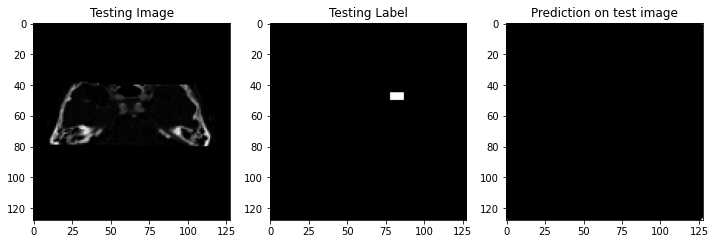

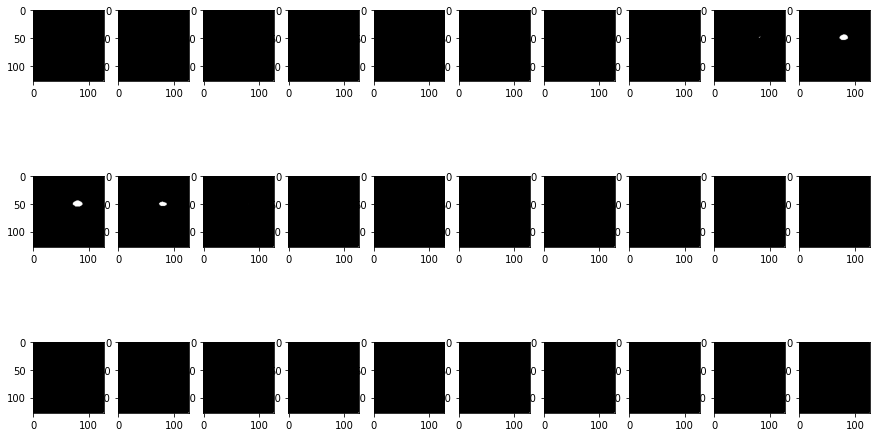

In [6]:
#test_img_number = random.randint(0, len(X_test))
test_img_number = 87
test_img = X_val[test_img_number]
ground_truth=y_val[test_img_number]

test_img_input = np.expand_dims(test_img, 0)

test_pred1 = best_model.predict(test_img_input)
#test_prediction1 = np.argmax(test_pred1, axis = 4)[0, :, :, :]
test_prediction1 = test_pred1[0, :, :, :, 0]
print(test_prediction1.shape)
ground_truth_argmax = ground_truth[:, :, :, 0]

##plot the individual slices from test predictions 

slice = 6  #6-7 !!!
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
x_t=np.transpose(test_img, (2, 1, 0, 3))
#x_t = x_t[:, :, :, 0]
plt.imshow(x_t[slice], cmap='gray')
#plt.imshow(test_img[slice,:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
plt.imshow(y_t[slice], cmap ='gray')

plt.subplot(233)
plt.title('Prediction on test image')
y_p = np.transpose(test_prediction1, (2, 1, 0))
plt.imshow(y_p[slice], cmap = 'gray')
plt.show()

plt.figure(figsize=(15,30))
for i in range(30):
    plt.subplot(10, 10, i+1)
    plt.imshow(y_p[(i+1)], cmap='gray')


In [7]:
plt.imsave("prediction.jpg", y_p[10], cmap = 'gray')
plt.imsave("ground_truth.jpg", y_t[slice], cmap = 'gray')
x_t = x_t[:, :, :, 0]
plt.imsave("patient_brain.jpg", x_t[slice], cmap = 'gray')
plt.imsave("patient_brain_1.jpg", vol[slice], cmap = 'gray')

x,y,w,h: 73 44 15 10


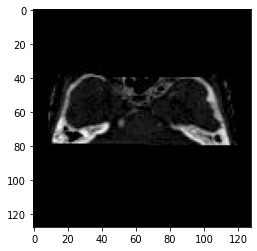

In [40]:
# import cv2
# import numpy as np
# import matplotlib
# from matplotlib import pyplot
# import matplotlib.patches as patches
img = cv2.imread('prediction.jpg')


# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(cntr, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)
 
# save resulting image
cv2.imwrite('pred_patient_7_39-43_threshold.jpg',img)      

# show thresh and result    
# cv2.imshow("bounding_box", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


image_p = matplotlib.image.imread("patient_brain_1.jpg")

figure, ax = pyplot.subplots(1)

rect1 = patches.Rectangle((x,y),w,h, edgecolor='r', facecolor="None", linewidth = 0, capstyle='round')
#rect2 = patches.Rectangle((27,50),13,13, edgecolor='r', facecolor="none")


ax.imshow(image_p)

ax.add_patch(rect1)
#ax.add_patch(rect2)

x,y,w,h: 78 45 9 5


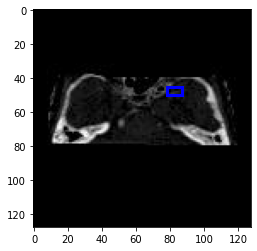

In [20]:
# read image
img = cv2.imread('ground_truth.jpg')

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(cntr, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)
 
# save resulting image
cv2.imwrite('prediction_threshold.jpg',img)      

# show thresh and result    
# cv2.imshow("bounding_box", result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#x_t = x_t[:, :, :, 0]
# plt.imsave("patient_brain_1.jpg", x_t[28], cmap = 'gray')
image_t = matplotlib.image.imread("patient_brain_1.jpg")

figure, ax = pyplot.subplots(1)

rect = patches.Rectangle((x,y),w,h, edgecolor='b', facecolor="none", linewidth = 3)

ax.imshow(image_t)

ax.add_patch(rect)

x,y,w,h: 73 44 15 10


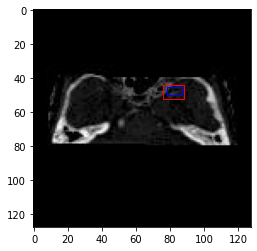

In [39]:
img = cv2.imread('prediction.jpg')


# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(cntr, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)
 
# save resulting image
cv2.imwrite('pred_patient_7_39-43_threshold.jpg',img)      

# show thresh and result    
# cv2.imshow("bounding_box", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


image_p = matplotlib.image.imread("patient_brain_1.jpg")

figure, ax = pyplot.subplots(1)

#rect1 = patches.Rectangle((x,y),w,h, edgecolor='r', facecolor="none")
rect1 = patches.Rectangle((76,44),12,8, edgecolor='r', facecolor="none", linewidth = 1)
rect2 = patches.Rectangle((78,45),9,5, edgecolor='b', facecolor="none", linewidth = 1)


ax.imshow(image_p)

ax.add_patch(rect1)
ax.add_patch(rect2)